In [2]:
!pip install -q pandas scikit-learn xgboost joblib


In [3]:
from google.colab import files
uploaded = files.upload()


Saving e-commerce_customer_behavior.csv to e-commerce_customer_behavior.csv


Shape: (500, 12)
   customer_id                    signup_date             last_purchase_date  \
0            1  2023-11-16 07:24:02.177365262  2024-02-29 07:24:02.177365262   
1            2  2023-11-22 15:12:42.146812999  2025-06-06 15:12:42.146812999   
2            3  2023-08-02 23:33:18.526729236  2023-10-21 23:33:18.526729236   
3            4  2024-12-26 01:59:53.815832010  2025-05-07 01:59:53.815832010   
4            5  2024-09-10 01:44:15.833247092  2025-01-25 01:44:15.833247092   

   total_orders  total_spent_usd  avg_order_value_usd  sessions_last_30d  \
0             9           438.57                48.73                  5   
1             5           402.05                80.41                 10   
2             5           169.15                33.83                  7   
3             9           560.70                62.30                 10   
4             4           677.72               169.43                  6   

   returns_rate  support_tickets         regi

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:05:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being s

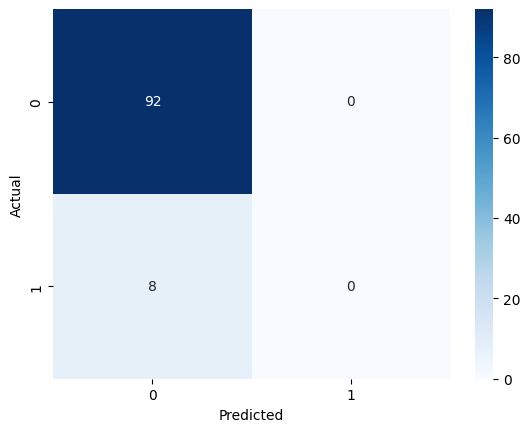

Sample Predictions: [0 0 0 0 0 0 0 0 0 0]


In [6]:

!pip install xgboost scikit-learn pandas matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv("e-commerce_customer_behavior.csv")
print("Shape:", df.shape)
print(df.head())


df['signup_date'] = pd.to_datetime(df['signup_date'], errors='coerce')
df['last_purchase_date'] = pd.to_datetime(df['last_purchase_date'], errors='coerce')
df['days_since_signup'] = (pd.to_datetime("today") - df['signup_date']).dt.days
df['days_since_last_purchase'] = (pd.to_datetime("today") - df['last_purchase_date']).dt.days

df = df.drop(columns=['signup_date', 'last_purchase_date'])


X = df.drop(columns=['is_churned', 'customer_id'])
y = df['is_churned']


numeric_features = X.select_dtypes(include=['int64','float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns


numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    ))
])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))



sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

preds = pipeline.predict(X_test[:10])
print("Sample Predictions:", preds)


In [7]:
import joblib

# Save trained pipeline
joblib.dump(pipeline, "churn_pipeline.joblib")
print("✅ Model saved as churn_pipeline.joblib")


✅ Model saved as churn_pipeline.joblib


In [8]:
import joblib
pipeline = joblib.load("churn_pipeline.joblib")
print("✅ Model loaded")


✅ Model loaded


In [9]:
# Load trained pipeline
pipeline = joblib.load("churn_pipeline.joblib")

def predict(df: pd.DataFrame):
    """
    Predict churn risk for customers.
    """
    df = df.copy()
    if "is_churned" in df.columns:
        df = df.drop(columns=["is_churned"])
    if "customer_id" in df.columns:
        customer_ids = df["customer_id"]
        df = df.drop(columns=["customer_id"])
    else:
        customer_ids = pd.Series([None] * len(df))

    proba = pipeline.predict_proba(df)[:, 1]
    labels = pipeline.predict(df)

    segment = pd.cut(
        proba,
        bins=[-0.01, 0.33, 0.66, 1.0],
        labels=["Low", "Medium", "High"]
    )

    return pd.DataFrame({
        "customer_id": customer_ids,
        "churn_probability": proba,
        "predicted_label": labels,
        "risk_segment": segment
    })


In [10]:
def predict(df: pd.DataFrame):
    """
    Takes a DataFrame with the same schema as the training data,
    adds engineered features, and returns churn predictions.
    """
    df = df.copy()


    df["signup_date"] = pd.to_datetime(df["signup_date"])
    df["last_purchase_date"] = pd.to_datetime(df["last_purchase_date"])


    df["days_since_signup"] = (pd.to_datetime("today") - df["signup_date"]).dt.days
    df["days_since_last_purchase"] = (pd.to_datetime("today") - df["last_purchase_date"]).dt.days


    if "is_churned" in df.columns:
        df = df.drop(columns=["is_churned"])


    if "customer_id" in df.columns:
        customer_ids = df["customer_id"]
        df = df.drop(columns=["customer_id"])
    else:
        customer_ids = pd.Series([None] * len(df))


    proba = pipeline.predict_proba(df)[:, 1]
    labels = pipeline.predict(df)


    segment = pd.cut(
        proba,
        bins=[-0.01, 0.33, 0.66, 1.0],
        labels=["Low", "Medium", "High"]
    )

    return pd.DataFrame({
        "customer_id": customer_ids,
        "churn_probability": proba,
        "predicted_label": labels,
        "risk_segment": segment
    })


In [11]:
df = pd.read_csv("e-commerce_customer_behavior.csv")
preds = predict(df)
preds.head(10)


,customer_id,churn_probability,predicted_label,risk_segment
0,1,0.000491,0,Low
1,2,0.001116,0,Low
2,3,0.000614,0,Low
3,4,0.000742,0,Low
4,5,0.000027,0,Low
5,6,0.011745,0,Low
6,7,0.943632,1,High
7,8,0.014705,0,Low
8,9,0.068125,0,Low
9,10,0.010696,0,Low


In [12]:
def generate_recommendations(row):
    if row["risk_segment"] == "High":
        if row["churn_probability"] > 0.8:
            return "Offer loyalty discount + personalized email"
        elif row["churn_probability"] > 0.6:
            return "Provide coupon + proactive support"
        else:
            return "Check engagement and send targeted offers"
    elif row["risk_segment"] == "Medium":
        return "Send re-engagement campaign"
    else:
        return "Maintain regular communication"

preds["recommendation"] = preds.apply(generate_recommendations, axis=1)
preds.head(10)


,customer_id,churn_probability,predicted_label,risk_segment,recommendation
0,1,0.000491,0,Low,Maintain regular communication
1,2,0.001116,0,Low,Maintain regular communication
2,3,0.000614,0,Low,Maintain regular communication
3,4,0.000742,0,Low,Maintain regular communication
4,5,0.000027,0,Low,Maintain regular communication
5,6,0.011745,0,Low,Maintain regular communication
6,7,0.943632,1,High,Offer loyalty discount + personalized email
7,8,0.014705,0,Low,Maintain regular communication
8,9,0.068125,0,Low,Maintain regular communication
9,10,0.010696,0,Low,Maintain regular communication


In [13]:
pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 76.5 MB/s eta 0:00:00


In [71]:
with open("stream_lit.py", "w") as f:
    f.write("""
import streamlit as st
import pandas as pd
import joblib

# ======================
# Page Config & Styling
# ======================
st.set_page_config(page_title="Customer Churn Prediction Agent", layout="wide")

# Background color styling
st.markdown(
    f'''
    <style>
        .stApp {{
            background-color: #e6f2ff;  /* Light blue */
        }}
    </style>
    ''',
    unsafe_allow_html=True
)

# Load trained pipeline
pipeline = joblib.load("churn_pipeline.joblib")

st.title("📊 Customer Churn Prediction Agent")

# ======================
# Reset Button
# ======================
if st.sidebar.button("🔄 Reset App"):
    st.cache_data.clear()
    st.cache_resource.clear()
    for key in list(st.session_state.keys()):
        del st.session_state[key]
    st.rerun()

st.write("Choose an option to predict churn:")

# ----------------------------
# Utility: Feature Engineering
# ----------------------------
def add_engineered_features(df):
    today = pd.Timestamp.today()
    if "signup_date" in df.columns:
        df["signup_date"] = pd.to_datetime(df["signup_date"], errors="coerce")
        df["days_since_signup"] = (today - df["signup_date"]).dt.days
    if "last_purchase_date" in df.columns:
        df["last_purchase_date"] = pd.to_datetime(df["last_purchase_date"], errors="coerce")
        df["days_since_last_purchase"] = (today - df["last_purchase_date"]).dt.days
        df["days_since_last_purchase"] = df["days_since_last_purchase"].fillna(9999)
    return df

# ----------------------------
# Risk Segmentation Logic
# ----------------------------
def get_label_and_recommend(proba):
    if proba >= 0.4:
        label = 1
        recommendation = "⚠️ High Risk: Immediate action required!"
    elif proba >= 0.2:
        label = 0
        recommendation = "🔄 Medium Risk: Engage with loyalty programs, send targeted campaigns."
    else:
        label = 0
        recommendation = "✅ Low Risk: Maintain engagement and upsell opportunities."
    return label, recommendation

# ----------------------------
# Option 1: Upload CSV
# ----------------------------
st.subheader("📂 Option 1: Upload Dataset")
uploaded_file = st.file_uploader("Upload CSV file", type="csv")

if uploaded_file is not None:
    df = pd.read_csv(uploaded_file)
    df = add_engineered_features(df)

    st.subheader("📄 Uploaded Data Preview")
    st.write(df.head())

    # Drop raw date columns; use engineered numeric features
    X = df.drop(columns=["customer_id", "is_churned", "signup_date", "last_purchase_date"], errors="ignore")
    proba = pipeline.predict_proba(X)[:, 1]

    preds = pd.DataFrame({
        "customer_id": df["customer_id"] if "customer_id" in df.columns else range(len(df)),
        "churn_probability": proba,
        "predicted_label": [get_label_and_recommend(p)[0] for p in proba],
        "recommendation": [get_label_and_recommend(p)[1] for p in proba]
    })

    st.subheader("🔮 Predictions")
    st.write(preds.head(10))

    csv = preds.to_csv(index=False).encode("utf-8")
    st.download_button("📥 Download Predictions", csv, "predictions.csv", "text/csv")

# ----------------------------
# Option 2: Manual Entry
# ----------------------------
st.subheader("✍️ Option 2: Manual Entry")

with st.form("manual_form"):
    customer_id = st.text_input("customer_id", "C001")

    # Dates with calendar picker
    signup_date = st.date_input("signup_date", value=pd.to_datetime("2025-04-01"))
    last_purchase_date = st.date_input("last_purchase_date", value=pd.to_datetime("2025-05-01"))

    # Numeric fields as text input (manual typing)
    total_orders = st.text_input("total_orders", "1")
    try:
        total_orders = int(total_orders)
    except:
        total_orders = 0

    total_spent_usd = st.text_input("total_spent_usd", "50.0")
    try:
        total_spent_usd = float(total_spent_usd)
    except:
        total_spent_usd = 0.0

    avg_order_value_usd = st.text_input("avg_order_value_usd", "50.0")
    try:
        avg_order_value_usd = float(avg_order_value_usd)
    except:
        avg_order_value_usd = 0.0

    sessions_last_30d = st.text_input("sessions_last_30d", "5")
    try:
        sessions_last_30d = int(sessions_last_30d)
    except:
        sessions_last_30d = 0

    returns_rate = st.text_input("returns_rate", "0.0")
    try:
        returns_rate = float(returns_rate)
    except:
        returns_rate = 0.0

    support_tickets = st.text_input("support_tickets", "0")
    try:
        support_tickets = int(support_tickets)
    except:
        support_tickets = 0

    region = st.text_input("region", "West")
    preferred_channel = st.selectbox("preferred_channel", ["Web", "Mobile App"])

    submitted = st.form_submit_button("Predict")

if submitted:
    manual_df = pd.DataFrame([{
        "customer_id": customer_id,
        "signup_date": pd.Timestamp(signup_date),
        "last_purchase_date": pd.Timestamp(last_purchase_date),
        "total_orders": total_orders,
        "total_spent_usd": total_spent_usd,
        "avg_order_value_usd": avg_order_value_usd,
        "sessions_last_30d": sessions_last_30d,
        "returns_rate": returns_rate,
        "support_tickets": support_tickets,
        "region": region,
        "preferred_channel": preferred_channel
    }])

    # Add engineered numeric features
    manual_df = add_engineered_features(manual_df)

    # Drop raw date columns; use numeric engineered features only
    X_manual = manual_df.drop(columns=["customer_id", "signup_date", "last_purchase_date"], errors="ignore")

    proba = pipeline.predict_proba(X_manual)[:, 1][0]
    label, rec = get_label_and_recommend(proba)

    st.write(f"**Churn Probability:** {proba:.2f}")
    st.write(f"**Predicted Label:** {'Churn' if label==1 else 'Not Churn'}")
    st.write(f"**Recommendation:** {rec}")
""")


In [72]:
!pip install pyngrok



In [ ]:
!ngrok config add-authtoken #authtoken#



Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [74]:
!kill $(lsof -t -i:8501) 2>/dev/null


In [75]:
!nohup streamlit run stream_lit.py --server.port 8501 --server.headless true > /dev/null 2>&1 &


In [76]:
from pyngrok import ngrok

ngrok.kill()  # cleanup old tunnels
public_url = ngrok.connect(8501)
print("🌍 Your Streamlit App is live at:", public_url)


🌍 Your Streamlit App is live at: NgrokTunnel: "https://3d7397d60498.ngrok-free.app" -> "http://localhost:8501"
